# **Import Necessary Dependencies and Libraries**

In [26]:
!pip install opendatasets

In [28]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision.models import VGG11_BN_Weights

import opendatasets as od
# Data handling libraries
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm
import copy

# Scikit-learn libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, ParameterGrid

# System and utilities
import sys
sys.path.append("path")
import warnings
warnings.filterwarnings("ignore")
import pickle

# File and folder manipulation
import os
import cv2
import shutil
import random
from IPython.display import FileLink

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from PIL import Image
import seaborn as sns
import plotly.express as px

# Time tracking
import time

# **Data Importing & Exploration**

## **Load Data**

In [35]:
#download dataset
od.download("https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sleekyucee
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset


100%|██████████| 38.4M/38.4M [00:00<00:00, 262MB/s]

In [36]:
#check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device:",device)

Device: cpu


In [39]:
#define data directory and subdirectories
data_dir = "/content/animal-image-classification-dataset"
animals_dir = os.path.join(data_dir, "Animals")
cats_dir = os.path.join(animals_dir, "cats")
snakes_dir = os.path.join(animals_dir, "snakes")
dogs_dir = os.path.join(animals_dir, "dogs")

In [41]:
#define train, validation, and test directory paths
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

#create sub directories for each animal type within train_dir, val_dir, and test_dir
for animal_type in ["cats", "snakes", "dogs"]:
    os.makedirs(os.path.join(train_dir, animal_type), exist_ok=True)
    os.makedirs(os.path.join(val_dir, animal_type), exist_ok=True)
    os.makedirs(os.path.join(test_dir, animal_type), exist_ok=True)

## **Explore Data**

In [40]:
#get the number of samples for each class
num_cats = len(os.listdir(cats_dir))
num_snakes = len(os.listdir(snakes_dir))
num_dogs = len(os.listdir(dogs_dir))

In [42]:
#display number of samples in each class
print(f"Number of samples in cats directory: {num_cats}")
print(f"\nNumber of samples in snakes directory: {num_snakes}")
print(f"\nNumber of samples in dogs directory: {num_dogs}")

#display total number of samples
total_samples = num_cats + num_snakes + num_dogs
print(f"\nTotal number of samples: {total_samples}")

Number of samples in cats directory: 1000

Number of samples in snakes directory: 1000

Number of samples in dogs directory: 1000

Total number of samples: 3000


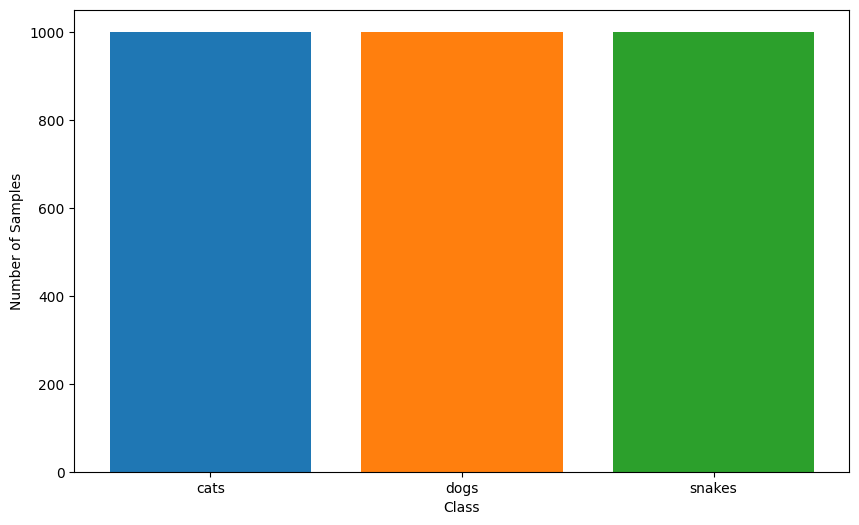

In [44]:
#bar plot to visualize number of samples
class_labels = ["cats", "dogs", "snakes"]
class_counts = [num_cats, num_dogs, num_snakes]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts, color=colors)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

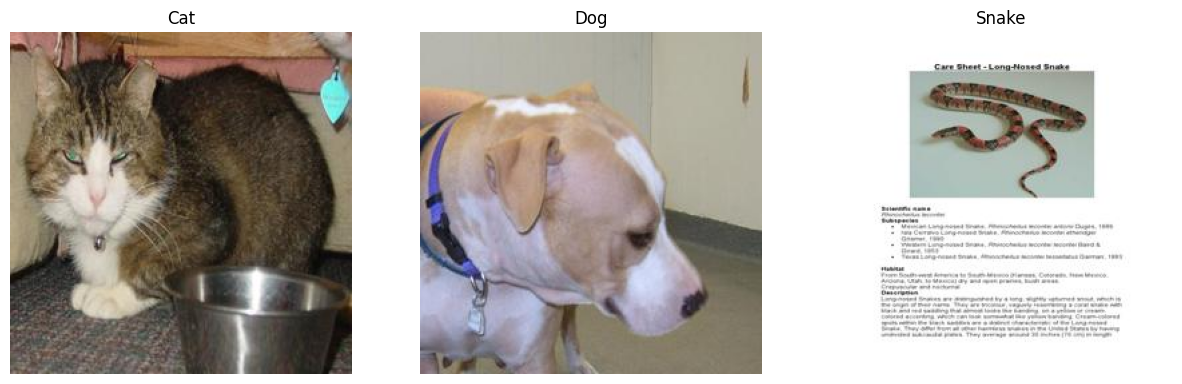

In [45]:
#display sample images of the classes of animal
sample_cat = os.path.join(cats_dir, os.listdir(cats_dir)[0])
sample_dog = os.path.join(dogs_dir, os.listdir(dogs_dir)[0])
sample_snake = os.path.join(snakes_dir, os.listdir(snakes_dir)[0])

#open and display the immages
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Image.open(sample_cat))
axs[0].set_title("Cat")
axs[0].axis("off")
axs[1].imshow(Image.open(sample_dog))
axs[1].set_title("Dog")
axs[1].axis("off")
axs[2].imshow(Image.open(sample_snake))
axs[2].set_title("Snake")
axs[2].axis("off")
plt.show()

In [64]:
#check random image shape
img1 = cv2.imread(sample_cat)
img2 = cv2.imread(sample_dog)
img3 = cv2.imread(sample_snake)
display(img1.shape, img2.shape, img3.shape)

(256, 256, 3)

(256, 256, 3)

(256, 256, 3)

## **Split Data**

In [46]:
#define split ratios
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

In [47]:
#define a function to split data into train_dir, val_dir, test_dir
def split_data(src_dir, train_dir, val_dir, test_dir, train_ratio, val_ratio, test_ratio):
    files = os.listdir(src_dir)
    random.shuffle(files)
    total_files = len(files)

    train_split = int(total_files * train_ratio)
    val_split = int(total_files * val_ratio)
    test_split = int(total_files * test_ratio)

    train_files = files[:train_split]
    val_files = files[train_split:(train_split + val_split)]
    test_files = files[(train_split + val_split):]

    for file in train_files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(train_dir, file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

    for file in val_files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(val_dir, file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

    for file in test_files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(test_dir, file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

In [50]:
#split data
split_data(cats_dir,
           os.path.join(train_dir, "cats"),
           os.path.join(val_dir, "cats"),
           os.path.join(test_dir, "cats"),
           train_ratio,
           val_ratio,
           test_ratio
)

split_data(dogs_dir,
           os.path.join(train_dir, "dogs"),
           os.path.join(val_dir, "dogs"),
           os.path.join(test_dir, "dogs"),
           train_ratio,
           val_ratio,
           test_ratio
)

split_data(snakes_dir,
           os.path.join(train_dir, "snakes"),
           os.path.join(val_dir, "snakes"),
           os.path.join(test_dir, "snakes"),
           train_ratio,
           val_ratio,
           test_ratio
)

In [52]:
#count samples in each class and directory after splitting
train_cats = len(os.listdir(os.path.join(train_dir, "cats")))
train_dogs = len(os.listdir(os.path.join(train_dir, "dogs")))
train_snakes = len(os.listdir(os.path.join(train_dir, "snakes")))

val_cats = len(os.listdir(os.path.join(val_dir, "cats")))
val_dogs = len(os.listdir(os.path.join(val_dir, "dogs")))
val_snakes = len(os.listdir(os.path.join(val_dir, "snakes")))

test_cats = len(os.listdir(os.path.join(test_dir, "cats")))
test_dogs = len(os.listdir(os.path.join(test_dir, "dogs")))
test_snakes = len(os.listdir(os.path.join(test_dir, "snakes")))

#total samples in each class
cats_total = train_cats + val_cats + test_cats
dogs_total = train_dogs + val_dogs + test_dogs
snakes_total = train_snakes + val_snakes + test_snakes

#total train, val, and test samples
train_total = train_cats + train_dogs + train_snakes
val_total = val_cats + val_dogs + val_snakes
test_total = test_cats + test_dogs + test_snakes

#total samples in entire dataset
total_samples = cats_total + dogs_total + snakes_total

#display counts
print(f"Cats - \nTrain: {train_cats}, \nVal: {val_cats}, \nTest: {test_cats}, \nTotal: {cats_total}")
print(f"\nDogs - \nTrain: {train_dogs}, \nVal: {val_dogs}, \nTest: {test_dogs}, \nTotal: {dogs_total}")
print(f"\nSnakes - \nTrain: {train_snakes}, \nVal: {val_snakes}, \nTest: {test_snakes}, \nTotal: {snakes_total}")
print(f"\nTotal Train: {train_total}, \nTotal Val: {val_total}, \nTotal Test: {test_total}, \nTotal Data: {total_samples}")

Cats - 
Train: 700, 
Val: 100, 
Test: 200, 
Total: 1000

Dogs - 
Train: 700, 
Val: 100, 
Test: 200, 
Total: 1000

Snakes - 
Train: 700, 
Val: 100, 
Test: 200, 
Total: 1000

Total Train: 2100, 
Total Val: 300, 
Total Test: 600, 
Total Data: 3000


## **Create DataFrames**

In [53]:
#initialize dict to store df of split data(train, val, test)
data_dict = {"train": None, "val": None, "test": None}

#loop through each split
for split, split_dir in [("train", train_dir), ("val", val_dir), ("test", test_dir)]:
    #initialize empty list to store data
    data = []

    for animal_type in ["cats", "dogs", "snakes"]:
        animal_dir = os.path.join(split_dir, animal_type)
        for image_name in os.listdir(animal_dir):
            data.append(
                {
                    "Label": animal_type,
                    "Image_Name": image_name,
                }
            )

    #create df from data
    data_dict[split] = pd.DataFrame(data)

#retrieve dataframes
train_df = data_dict["train"]
val_df = data_dict["val"]
test_df = data_dict["test"]

In [60]:
#display 5 random rows of train df, val df, and test df
display(train_df.sample(5), val_df.sample(5), test_df.sample(5))

,Label,Image_Name
786,dogs,1_0424.jpg
1071,dogs,1_0882.jpg
791,dogs,1_0004.jpg
1630,snakes,2_0472.jpg
1738,snakes,2_0131.jpg


,Label,Image_Name
103,dogs,1_0183.jpg
212,snakes,2_0345.jpg
5,cats,0_0137.jpg
147,dogs,1_0099.jpg
201,snakes,2_0653.jpg


,Label,Image_Name
488,snakes,2_0820.jpg
114,cats,0_0211.jpg
493,snakes,2_0842.jpg
414,snakes,2_0399.jpg
503,snakes,2_0912.jpg


## **Labels to Numeric**

In [61]:
#retrieve class names from labels and map classes to numbers
for df in [train_df, val_df, test_df]:
    class_names = df["Label"].unique()
    class_to_num = {class_name: i for i, class_name in enumerate(class_names)}
    df["Label"] = df["Label"].map(class_to_num)

In [62]:
#view changes
display(train_df.sample(5), val_df.sample(5), test_df.sample(5))

,Label,Image_Name
1424,2,2_0949.jpg
1166,1,1_0219.jpg
1928,2,2_0950.jpg
1515,2,2_0613.jpg
27,0,0_0463.jpg


,Label,Image_Name
192,1,1_0748.jpg
108,1,1_0317.jpg
107,1,1_0817.jpg
294,2,2_0389.jpg
10,0,0_0199.jpg


,Label,Image_Name
492,2,2_0617.jpg
104,0,0_0408.jpg
539,2,2_0337.jpg
274,1,1_0324.jpg
394,1,1_0683.jpg


In [65]:
#save train, val, and test data as csv files
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

## **Data Transformations**